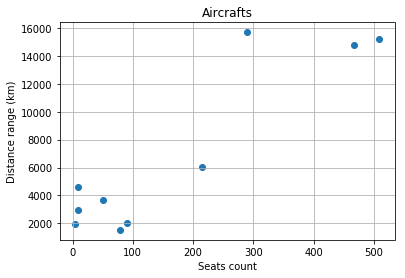

In [1624]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import pandas as pd

X=np.array([(4,1940),(9,2960),(9,4630),(78,1528),(90,2040),(50,3700),(467,14815),(509,15200),(290,15700),(215,6045)])

x1 = np.array(X[:,0])
x2 = np.array(X[:,1])

fig, ax = plt.subplots()
ax.scatter(x1,x2)
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts')
ax.grid()
plt.show()

In [1625]:
train_data = np.array(X)
max_values = train_data.max(0)

X_norm = np.divide(train_data,max_values)

x1 = np.array(X_norm[:,0])
x2 = np.array(X_norm[:,1])

print(X_norm)

data_set=X_norm
groups = 2
space=[[0,1],[0,1]]

error_margin = 0.1
m = 2.0

assignation=np.zeros((len(X),groups))
assignation_entry = assignation

[[0.00785855 0.12356688]
 [0.01768173 0.18853503]
 [0.01768173 0.29490446]
 [0.15324165 0.09732484]
 [0.17681729 0.12993631]
 [0.09823183 0.23566879]
 [0.91748527 0.94363057]
 [1.         0.96815287]
 [0.5697446  1.        ]
 [0.42239686 0.38503185]]


In [1626]:
import random

centers = []
etas = []

def select_centers():
    global centers
    global groups
    global space
    iter=0
    while iter<groups:
        centers.append((random.uniform(space[0][0],space[0][1]), 
                        random.uniform(space[1][0],space[1][1])))
        iter=iter+1
        
select_centers()
print(centers)

[(0.8434370598709583, 0.5671253262594108), (0.4210361237641699, 0.6128883614683087)]


First of all we need to initialize assignation matrix. Fuzzy k-means will be the most efficient for that.

In [1627]:
def calculate_distance(x,v):
    return np.sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

In [1628]:
def calculate_init_u(x, i):
    global centers
    if i == 0:
        sum=1.0+(calculate_distance(x, centers[0])/calculate_distance(x, centers[1]))**2
    else:
        sum=1.0+(calculate_distance(x, centers[1])/calculate_distance(x, centers[0]))**2
    return sum**-1

In [1629]:
def calculate_new_centers(u):
    global centers
    global groups
    new_centers = []
    for c in range(groups):
        u_x_vector = np.zeros(2)
        u_scalar=0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar + (u[i][c]**m)
            u_x_vector = np.add(u_x_vector,np.multiply(u[i][c]**m,data_set[i]))
        new_centers.append(np.divide(u_x_vector, u_scalar))
    centers=new_centers

Just one loop without any check for initialization.

In [1630]:
def init_u_matrix():
    global assignation
    global assignation_entry
    global groups
    new_assignation = []
    for i in range(len(data_set)):
        new_assignation_vector = []
        for k in range(groups):
            new_assignation_vector.append(calculate_init_u(data_set[i], k))
        new_assignation.append(new_assignation_vector)
    calculate_new_centers(new_assignation)
    assignation = new_assignation
    assignation_entry = assignation

PCM Implementation

Mahalanobis Distance

In [1631]:
global covariance_matrix
covariance_matrix = np.cov(x1,x2)
invcovmx = inv(covariance_matrix)
def calculate_mahalanobis_distance(x,v, inv_cov_matrix):
    vec=[a - b for a, b in zip(x, v)]
    vec_array=np.array(vec)
    return math.sqrt( (vec_array.T.dot(inv_cov_matrix)).dot( vec_array ) )

def calculate_mahalanobis_distance_sqr(x,v, inv_cov_matrix):
    vec=[a - b for a, b in zip(x, v)]
    vec_array=np.array(vec)
    return (vec_array.T.dot(inv_cov_matrix)).dot( vec_array )

PDM is a measure for assignation entries and will be used to calculate future assignations

In [1632]:
def calculate_pdm(x,u):
    global centers
    global etas
    new_etas = []
    for c in range(groups):
        u_x_scalar = 0.0
        u_scalar = 0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar + (u[i][c]**m)
            u_x_scalar= u_x_scalar + (u[i][c]**m * calculate_mahalanobis_distance_sqr(x, centers[c], invcovmx))
        new_etas.append(np.divide(u_x_scalar,u_scalar))
    return new_etas

For more complex solutions and clustering tasks calculating U matrix should conists of arrays iterations. For convieniance I have made similar method like simple fuzzy and k-means from classes.

In [1633]:
def calculate_u(x,i):
    global centers
    global assignation_entry
    local_u = 0
    if i == 0:
        local_u = 1.0 + (calculate_mahalanobis_distance(x, centers[0], invcovmx)/calculate_pdm(x, assignation_entry)[1])**2
    else:
        local_u = 1.0 + (calculate_mahalanobis_distance(x, centers[1], invcovmx)/calculate_pdm(x, assignation_entry)[0])**2
    return local_u**-1

In [1634]:
def calculate_differences(new_assignation):
    global assignation    
    return np.sum(np.abs(np.subtract(assignation,new_assignation)))

Testing PCM

In [1635]:
def cluster():
    global assignation    
    global error_margin    
    global groups
    difference_limit_not_achieved=True
    iter=0
    init_u_matrix()
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation_vector=[]
            for k in range(groups):
                new_assignation_vector.append(calculate_u(data_set[i], k))
            new_assignation.append(new_assignation_vector)
        calculate_new_centers(new_assignation)

        if iter>0:
            if calculate_differences(new_assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1

[[0.00456943797508024, 0.9931092940496113], [0.01116748691799031, 0.988126552081162], [0.2037080447099236, 0.95149247214412], [0.19605874132170645, 0.9575369941663862], [0.16944899459314447, 0.9559567530550296], [0.00043159179709103445, 0.9968249381362547], [0.9789685283891536, 0.03317348993751163], [0.9656861325670066, 0.16121512888059583], [0.9125487161057081, 0.6937006262359471], [0.3590890858158647, 0.8300695132448872]]


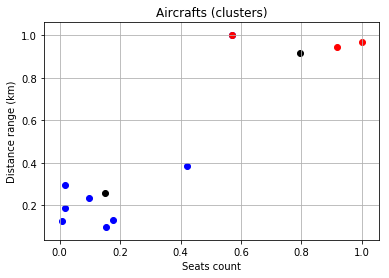

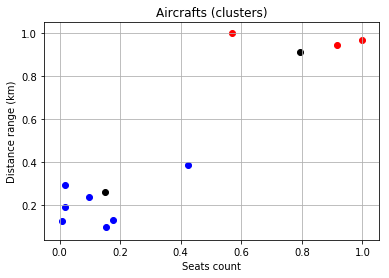

In [1636]:
cluster()
print(assignation)
red = X_norm[np.where(np.array(assignation)[:,0] > 0.5)]
blue = X_norm[np.where(np.array(assignation)[:,1] > 0.5)]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

red = X_norm[np.where(np.array(assignation)[:,0] > np.array(assignation)[:,1])]
blue = X_norm[np.where(np.array(assignation)[:,1] > np.array(assignation)[:,0])]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

Results from PCM implementation are very comparable to Fuzzy k-means. Thus, it can be noticable that one record has not been assigned properly. According to scholar articles pure PCM is not always efficent. However combining it with Fuzzy k-means(PFCM) should improve results. Creating new assignment condition improves results on grid. 